In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
! git clone https://github.com/amirgholami/adahessian.git #original, if we want to modify something need to replace with a forked one

Cloning into 'adahessian'...
remote: Enumerating objects: 562, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 562 (delta 90), reused 164 (delta 84), pack-reused 387
Receiving objects: 100% (562/562), 2.00 MiB | 5.08 MiB/s, done.
Resolving deltas: 100% (202/202), done.


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Opti-ML') #to access other files
sys.path.insert(0,"adahessian/image_classification/")

In [ ]:
# Useful starting lines
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision

from optim_adahessian import Adahessian

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load a dataset and visualize it
run only one cell of dataset

In [ ]:
# fun dataset (but not all commands works ... ))
train_data=datasets.GTSRB(root='data',split="train",download=True,transform=ToTensor()) #road sign https://benchmark.ini.rub.de/gtsrb_news.html
test_data=datasets.GTSRB(root='data',split="test",download=True,transform=ToTensor())

100%|██████████| 187490228/187490228 [00:12<00:00, 14802026.90it/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


100%|██████████| 88978620/88978620 [00:06<00:00, 13931297.96it/s]


Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 208564.66it/s]


Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb


In [ ]:
# classic dataset 
train_data=datasets.CIFAR10(root='data',train=True,download=True,transform=ToTensor())
test_data=datasets.CIFAR10(root='data',train=False,download=True,transform=ToTensor())

100%|██████████| 170498071/170498071 [00:04<00:00, 36504764.38it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
print("train data of type:",type(train_data),"with length",len(train_data))
print("test data of type:",type(test_data),"with length",len(test_data))

train data of type: <class 'torchvision.datasets.cifar.CIFAR10'> with length 50000
test data of type: <class 'torchvision.datasets.cifar.CIFAR10'> with length 10000


In [ ]:
print("samples of type",type(train_data[0]),"with length",len(train_data[0]))
print("   - First entry: Image of type",type(train_data[0][0]),"and size",train_data[0][0].size())
print("   - Second entry: Label of type",type(train_data[0][1]))
print("The first sample:\n",train_data[0])

samples of type <class 'tuple'> with length 2
   - First entry: Image of type <class 'torch.Tensor'> and size torch.Size([3, 32, 32])
   - Second entry: Label of type <class 'int'>
The first sample:
 (tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627

In [ ]:
labels=np.unique(np.array(train_data.targets)) #don't seem to work for all datasets 
print(labels)

[0 1 2 3 4 5 6 7 8 9]


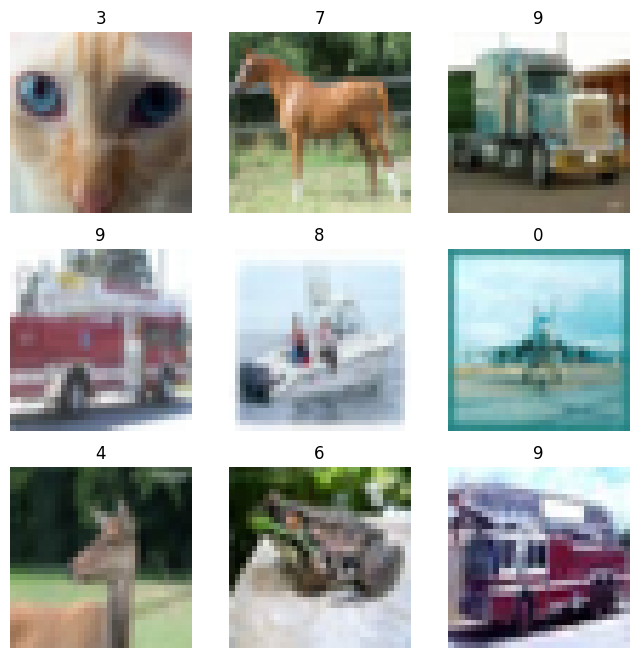

In [ ]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()

## The rest of the code is widley copied from [cifar10_tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [ ]:
trainloader = DataLoader(train_data, batch_size=5, shuffle=True) #change batch size with our need
testloader = DataLoader(test_data, batch_size=5, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [ ]:
# model: A neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5,out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
# optimization: a loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# training:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.303
[1,  4000] loss: 2.304
[1,  6000] loss: 2.303
[1,  8000] loss: 2.304
[1, 10000] loss: 2.304
[2,  2000] loss: 2.303
[2,  4000] loss: 2.304
[2,  6000] loss: 2.304
[2,  8000] loss: 2.304
[2, 10000] loss: 2.304
Finished Training


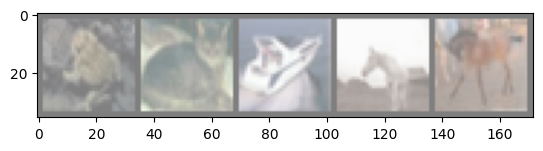

GroundTruth:  frog  cat   ship  horse
Predicted:  frog  frog  frog  frog 


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 100.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %
